## 1. Import Libraries

In [85]:
from os.path import join
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
pd.options.mode.chained_assignment = None

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import math

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, mean_squared_error, make_scorer, mean_absolute_error, mean_absolute_percentage_error

## 2. Merge all trip_metrics

In [86]:
#from google.colab import drive
#drive.mount('/content/drive')

In [87]:
trip_metrics_1 = pd.read_csv("../Yeni dosyalar/trip_metrics_1-6.csv")
trip_metrics_2 = pd.read_csv("../Yeni dosyalar/trip_metrics_7-12.csv")
trip_metrics_3 = pd.read_csv("../Yeni dosyalar/trip_metrics_13-18.csv")
trip_metrics_4 = pd.read_csv("../Yeni dosyalar/trip_metrics_19-24.csv")
trip_metrics_5 = pd.read_csv("../Yeni dosyalar/trip_metrics_25-30.csv")

df_list = [trip_metrics_1,trip_metrics_2,trip_metrics_3,trip_metrics_4,trip_metrics_5]
trips_merged = pd.concat(df_list)
trips_merged.to_csv('trips_merged.csv',index=False)



In [88]:
# if you have all data just use this method
trips_merged = pd.read_csv("../Yeni dosyalar/trips_merged.csv")
trips_merged

,ID,Energy_Consumption_kWh,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,...,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean,State_Name
0,vehicle_106_2013-01-02_trip_1,56.512577,2013-01-02 17:03:03,2013-01-03 06:59:37,30054,3.059713,25.543506,53.10822,0.0,0.682558,...,-36.0,186.0,0.0,27.401732,-0.701630,2538.156197,32.138279,0.094478,2.167538,New York
1,vehicle_106_2013-01-03_trip_1,67.325737,2013-01-03 07:00:39,2013-01-04 06:59:01,61184,5.406763,91.890939,54.71756,0.0,0.652998,...,-18.0,154.0,0.0,19.594187,0.645511,2509.308584,-4.814485,-0.027146,1.835317,New York
2,vehicle_106_2013-01-04_trip_1,73.932923,2013-01-04 07:00:03,2013-01-05 06:45:37,65658,0.615856,11.232193,54.71756,0.0,0.654898,...,-25.0,100.0,0.0,14.865846,2.540228,2507.926606,99.693687,0.191294,1.923882,New York
3,vehicle_106_2013-01-05_trip_1,-113.205677,2013-01-05 07:12:24,2013-01-06 01:34:20,52863,18.642805,273.754051,54.71756,0.0,0.620325,...,-134.0,405.0,0.0,56.241256,4.485057,2517.485382,-6.452550,-0.015366,2.153184,New York
4,vehicle_106_2013-01-07_trip_1,0.082100,2013-01-08 03:24:30,2013-01-08 06:59:59,12929,0.000875,0.003143,1.60934,0.0,0.447039,...,-4.0,55.0,0.0,20.422091,8.330394,2499.255762,65241.277748,91728.000000,2.113689,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10314,vehicle_441_2015-01-07_trip_1,48.259822,2015-01-07 09:16:14,2015-01-08 01:38:05,6153,30.360591,51.891309,54.71756,0.0,0.615739,...,-37.0,118.0,0.0,25.376619,-6.627231,NaN,-0.303934,-0.000381,1.809065,New Jersey
10315,vehicle_441_2015-01-08_trip_1,50.762781,2015-01-08 07:40:24,2015-01-09 01:09:45,6965,28.826084,55.770466,54.71756,0.0,0.601900,...,-43.0,94.0,0.0,25.596772,-10.669776,NaN,-0.565587,-0.000774,1.791352,New Jersey
10316,vehicle_441_2015-01-09_trip_1,44.076312,2015-01-09 07:02:21,2015-01-10 01:01:30,5877,27.029152,44.125091,54.71756,0.0,0.625577,...,-23.0,103.0,0.0,28.478131,-3.154897,NaN,-8.202602,-0.008253,1.778323,New Jersey
10317,vehicle_441_2015-01-10_trip_1,41.304916,2015-01-10 09:12:36,2015-01-11 00:05:32,6125,23.705111,40.331612,54.71756,0.0,0.615101,...,-57.0,123.0,0.0,29.333582,-8.270477,NaN,13.646722,0.014555,1.676657,New Jersey


## 3. Splitting the data to train test

In [89]:
## handling the energy consumption values by dropping rows with value 0 and takinbg absolute value to remove negative consumptions
trips_merged['Energy_Consumption_kWh'] = trips_merged['Energy_Consumption_kWh'] / trips_merged['Total_Distance_km']
trips_merged = trips_merged.rename(columns={"Energy_Consumption_kWh": "Energy_Consumption_kWh/km"})
trips_merged = trips_merged[trips_merged['Energy_Consumption_kWh/km'] !=0]
trips_merged['Energy_Consumption_kWh/km'] = trips_merged['Energy_Consumption_kWh/km'].abs()

In [90]:
state_dict = ['Nebraska','内蒙古自治区','Алматы облысы','Pays de la Loire','Comunitat Valenciana','Michigan', None]
trips_merged['State_Name']  = trips_merged['State_Name'].replace(state_dict, 'Unknown')
trips_merged['State_Name'].unique()

array(['New York', 'Unknown', 'Indiana', 'Missouri', 'California',
       'Washington', 'Arizona', 'Maryland', 'District of Columbia',
       'New Jersey', 'Illinois', 'Wisconsin', 'Virginia'], dtype=object)

In [91]:
trips_merged = trips_merged.dropna()

In [92]:
cols_to_keep = ['Duration_s', 'Average_Speed_kmh', 'Max_Speed',
       'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude',
       'Min_Altitude', 'GPS_Altitude_Mean', 'Average_Ambient_Temperature',
       'Average_air', 'Kinetic_Intensity', 'Traffic_Category_Mean',
       'State_Name','Total_Distance_km']

In [93]:
X = trips_merged[cols_to_keep]
y = trips_merged['Energy_Consumption_kWh/km']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55, stratify=X['State_Name'])

<Axes: >

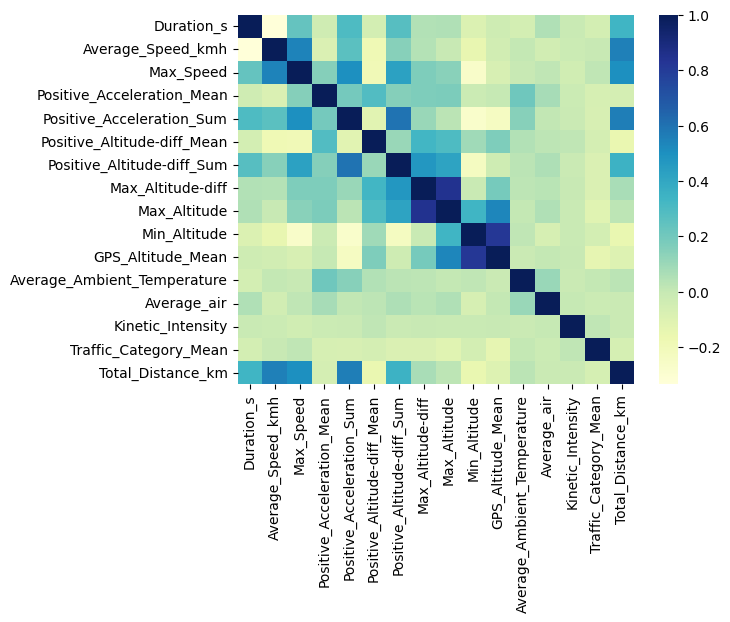

In [94]:
sns.heatmap(X_train.drop(columns=["State_Name"]).corr(), cmap="YlGnBu")

<Axes: >

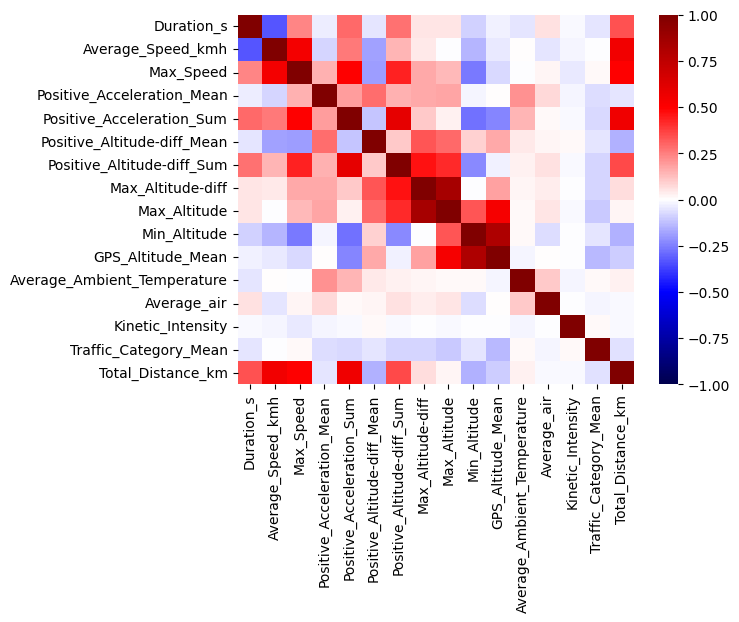

In [95]:
vmin = -1
vmax = 1
cmap = sns.color_palette(["red", "white", "green"])
sns.heatmap(X_train.drop(columns=["State_Name"]).corr(), cmap = "seismic" ,center=0,  fmt=".1f", vmin=vmin, vmax=vmax,)

In [96]:
X_train.drop(columns=['State_Name']).corr()


,Duration_s,Average_Speed_kmh,Max_Speed,Positive_Acceleration_Mean,Positive_Acceleration_Sum,Positive_Altitude-diff_Mean,Positive_Altitude-diff_Sum,Max_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Kinetic_Intensity,Traffic_Category_Mean,Total_Distance_km
Duration_s,1.000000,-0.335412,0.236396,-0.033616,0.296136,-0.049835,0.273974,0.048775,0.053641,-0.087091,-0.030878,-0.049144,0.054742,-0.009583,-0.052522,0.336010
Average_Speed_kmh,-0.335412,1.000000,0.545242,-0.081836,0.259605,-0.181970,0.144940,0.043003,-0.002885,-0.142724,-0.044223,0.004714,-0.048402,-0.018163,-0.005600,0.552004
Max_Speed,0.236396,0.545242,1.000000,0.152290,0.504289,-0.193800,0.430602,0.167148,0.139337,-0.264120,-0.070509,-0.003380,0.018389,-0.039885,0.014217,0.500842
Positive_Acceleration_Mean,-0.033616,-0.081836,0.152290,1.000000,0.193427,0.285542,0.152343,0.168883,0.173829,-0.021701,0.003328,0.211480,0.073437,-0.021040,-0.065869,-0.054001
Positive_Acceleration_Sum,0.296136,0.259605,0.504289,0.193427,1.000000,-0.115702,0.595417,0.106947,0.025149,-0.274821,-0.238420,0.147174,0.009624,-0.015029,-0.074438,0.559089
Positive_Altitude-diff_Mean,-0.049835,-0.181970,-0.193800,0.285542,-0.115702,1.000000,0.107012,0.328399,0.295862,0.088567,0.165560,0.045669,0.020230,0.014988,-0.054384,-0.155333
Positive_Altitude-diff_Sum,0.273974,0.144940,0.430602,0.152343,0.595417,0.107012,1.000000,0.468187,0.418455,-0.231183,-0.030378,0.029500,0.057311,-0.013725,-0.081025,0.352323
Max_Altitude-diff,0.048775,0.043003,0.167148,0.168883,0.106947,0.328399,0.468187,1.000000,0.848509,-0.007229,0.186280,0.022049,0.034353,-0.001569,-0.080002,0.068202
Max_Altitude,0.053641,-0.002885,0.139337,0.173829,0.025149,0.295862,0.418455,0.848509,1.000000,0.334226,0.533532,0.007822,0.052421,-0.010053,-0.108342,0.022998
Min_Altitude,-0.087091,-0.142724,-0.264120,-0.021701,-0.274821,0.088567,-0.231183,-0.007229,0.334226,1.000000,0.819576,0.015516,-0.064220,-0.007256,-0.053183,-0.151131


## 4. Feature Enginnering

In [97]:
X_train = pd.get_dummies(X_train, columns=['State_Name'], prefix="",prefix_sep="") 
X_test = pd.get_dummies(X_test, columns=['State_Name'], prefix="",prefix_sep="") 

 ## 5. BaseLine Classifier

In [98]:
def custom_metric(predictions, actual_values):
    if(actual_values == 0):
        return 0
    error = abs(predictions - actual_values) / actual_values
    if error <= 0.1:
        return 1
    else:
        return 0

In [99]:
consumption_mean = y.mean()

df_temp = pd.DataFrame(y)
df_temp['baseline'] = consumption_mean
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['baseline'], row['Energy_Consumption_kWh/km']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Baseline Accuracy is:',accuracy)

Baseline Accuracy is: 0.005516959542296689


## 6. Applying Machine Learning Models

### 6.1 Random Forest

In [100]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

mse = mean_absolute_error(y_test, predictions)
print(mse)


7.828122791922923


In [101]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['predictions'], row['Energy_Consumption_kWh/km']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

Accuracy is: 0.5209397344228804


### 6.2 XGBoost

In [102]:
mse = make_scorer(mean_squared_error)
params = {
    'max_depth': [9],
 
    'subsample':[0.9],
    'colsample_bytree':[0.9],
    'gamma':[0.3]
}

# create an XGB Boost instance
xgb_reg = XGBRegressor(

  
)

# searching the model
XGB_Model= GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=mse)


In [103]:
XGB_Model.fit(X_train, y_train)
predictions = XGB_Model.predict(X_test)

mse = mean_absolute_error(y_test, predictions)
print(mse)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
5.3424121107532425


In [104]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['predictions'], row['Energy_Consumption_kWh/km']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

Accuracy is: 0.47088866189989786


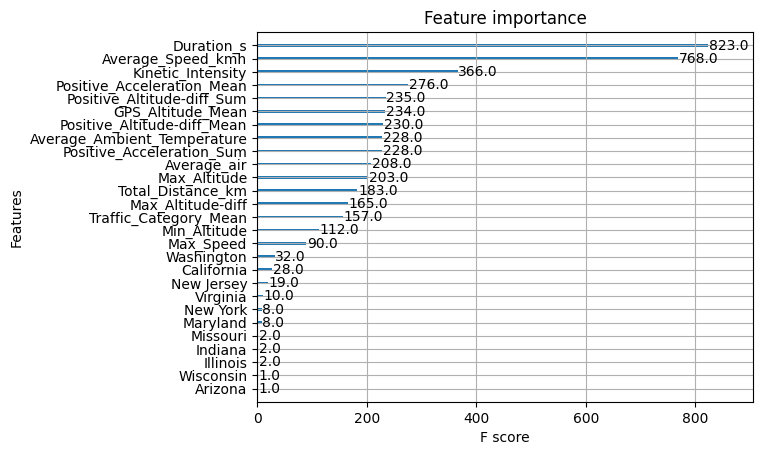

In [105]:
from xgboost import plot_importance
plot_importance(XGB_Model.best_estimator_)
plt.show()

### 6.3 Extra Trees

In [106]:
clf = ExtraTreesRegressor(n_estimators = 500)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

mse = mean_absolute_error(y_test, predictions)
print(mse)


5.90849100200051


In [107]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['predictions'], row['Energy_Consumption_kWh/km']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

Accuracy is: 0.5377936670071501
